# Seleção da Database
## Database: 
Brazilian E-Commerce Public Database by Olist
https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv

### Descrição: 
A database foi provida pela Olist, uma empresa de marketplace situada no Brasil. A Olist conecta pequenos negócios por todo o Brasil de uma forma simples. Vendedores conseguem vender seus produtos diretamente pela Olist Store, as entregas são feitas por meio de parceiros.

### Problema de Negócio:
Quais são os principais fatores que alavancam o número de vendas? Quais os fatores que impactam na avaliação do cliente?

### Perguntas:
- 1. Como as vendas foram afetadas entre 2016 e 2018?

- 2. Existe diferença significativa de venda para cada um dos seguintes fatores:
    - Mês
    - Dia da Semana
    - Método de Pagamento
    - Região   
   
- 3. Quais produtos e categoria possuem maiores vendas?
   
- 4. As notas de review do produto possuem impacto no número de vendas?
    - Realizar plot de nuvem de palavras

- 5. A localização impacta no tempo de entrega?
    - Heatmap por localização (Mapa)

- 6. O tempo de entrega impacta no review do produto?

- 7. Quais categorias são mais consumidas por região?
    - Diferentes regiões possuem maior adesão por diferentes tipos de produto?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import string
import nltk
import os
import folium
import mpl_toolkits
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

from warnings import simplefilter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
from datetime import datetime, timedelta
from plotly.subplots import make_subplots

In [2]:
os.environ['PROJ_LIB'] = '/Users/herik/anaconda3/Library/share/proj'

In [3]:
from mpl_toolkits.basemap import Basemap

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher e João Hutner" --iversions

Author: Herikc Brecher e João Hutner

plotly    : 5.1.0
numpy     : 1.19.5
folium    : 0.12.1
re        : 2.2.1
seaborn   : 0.11.1
matplotlib: 3.2.0
pandas    : 1.2.4
nltk      : 3.6.1



In [5]:
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
pyoff.init_notebook_mode()
sns.set_theme()

In [6]:
seed_ = 194
np.random.seed(seed_)

# 1. Carregamento dos Dados

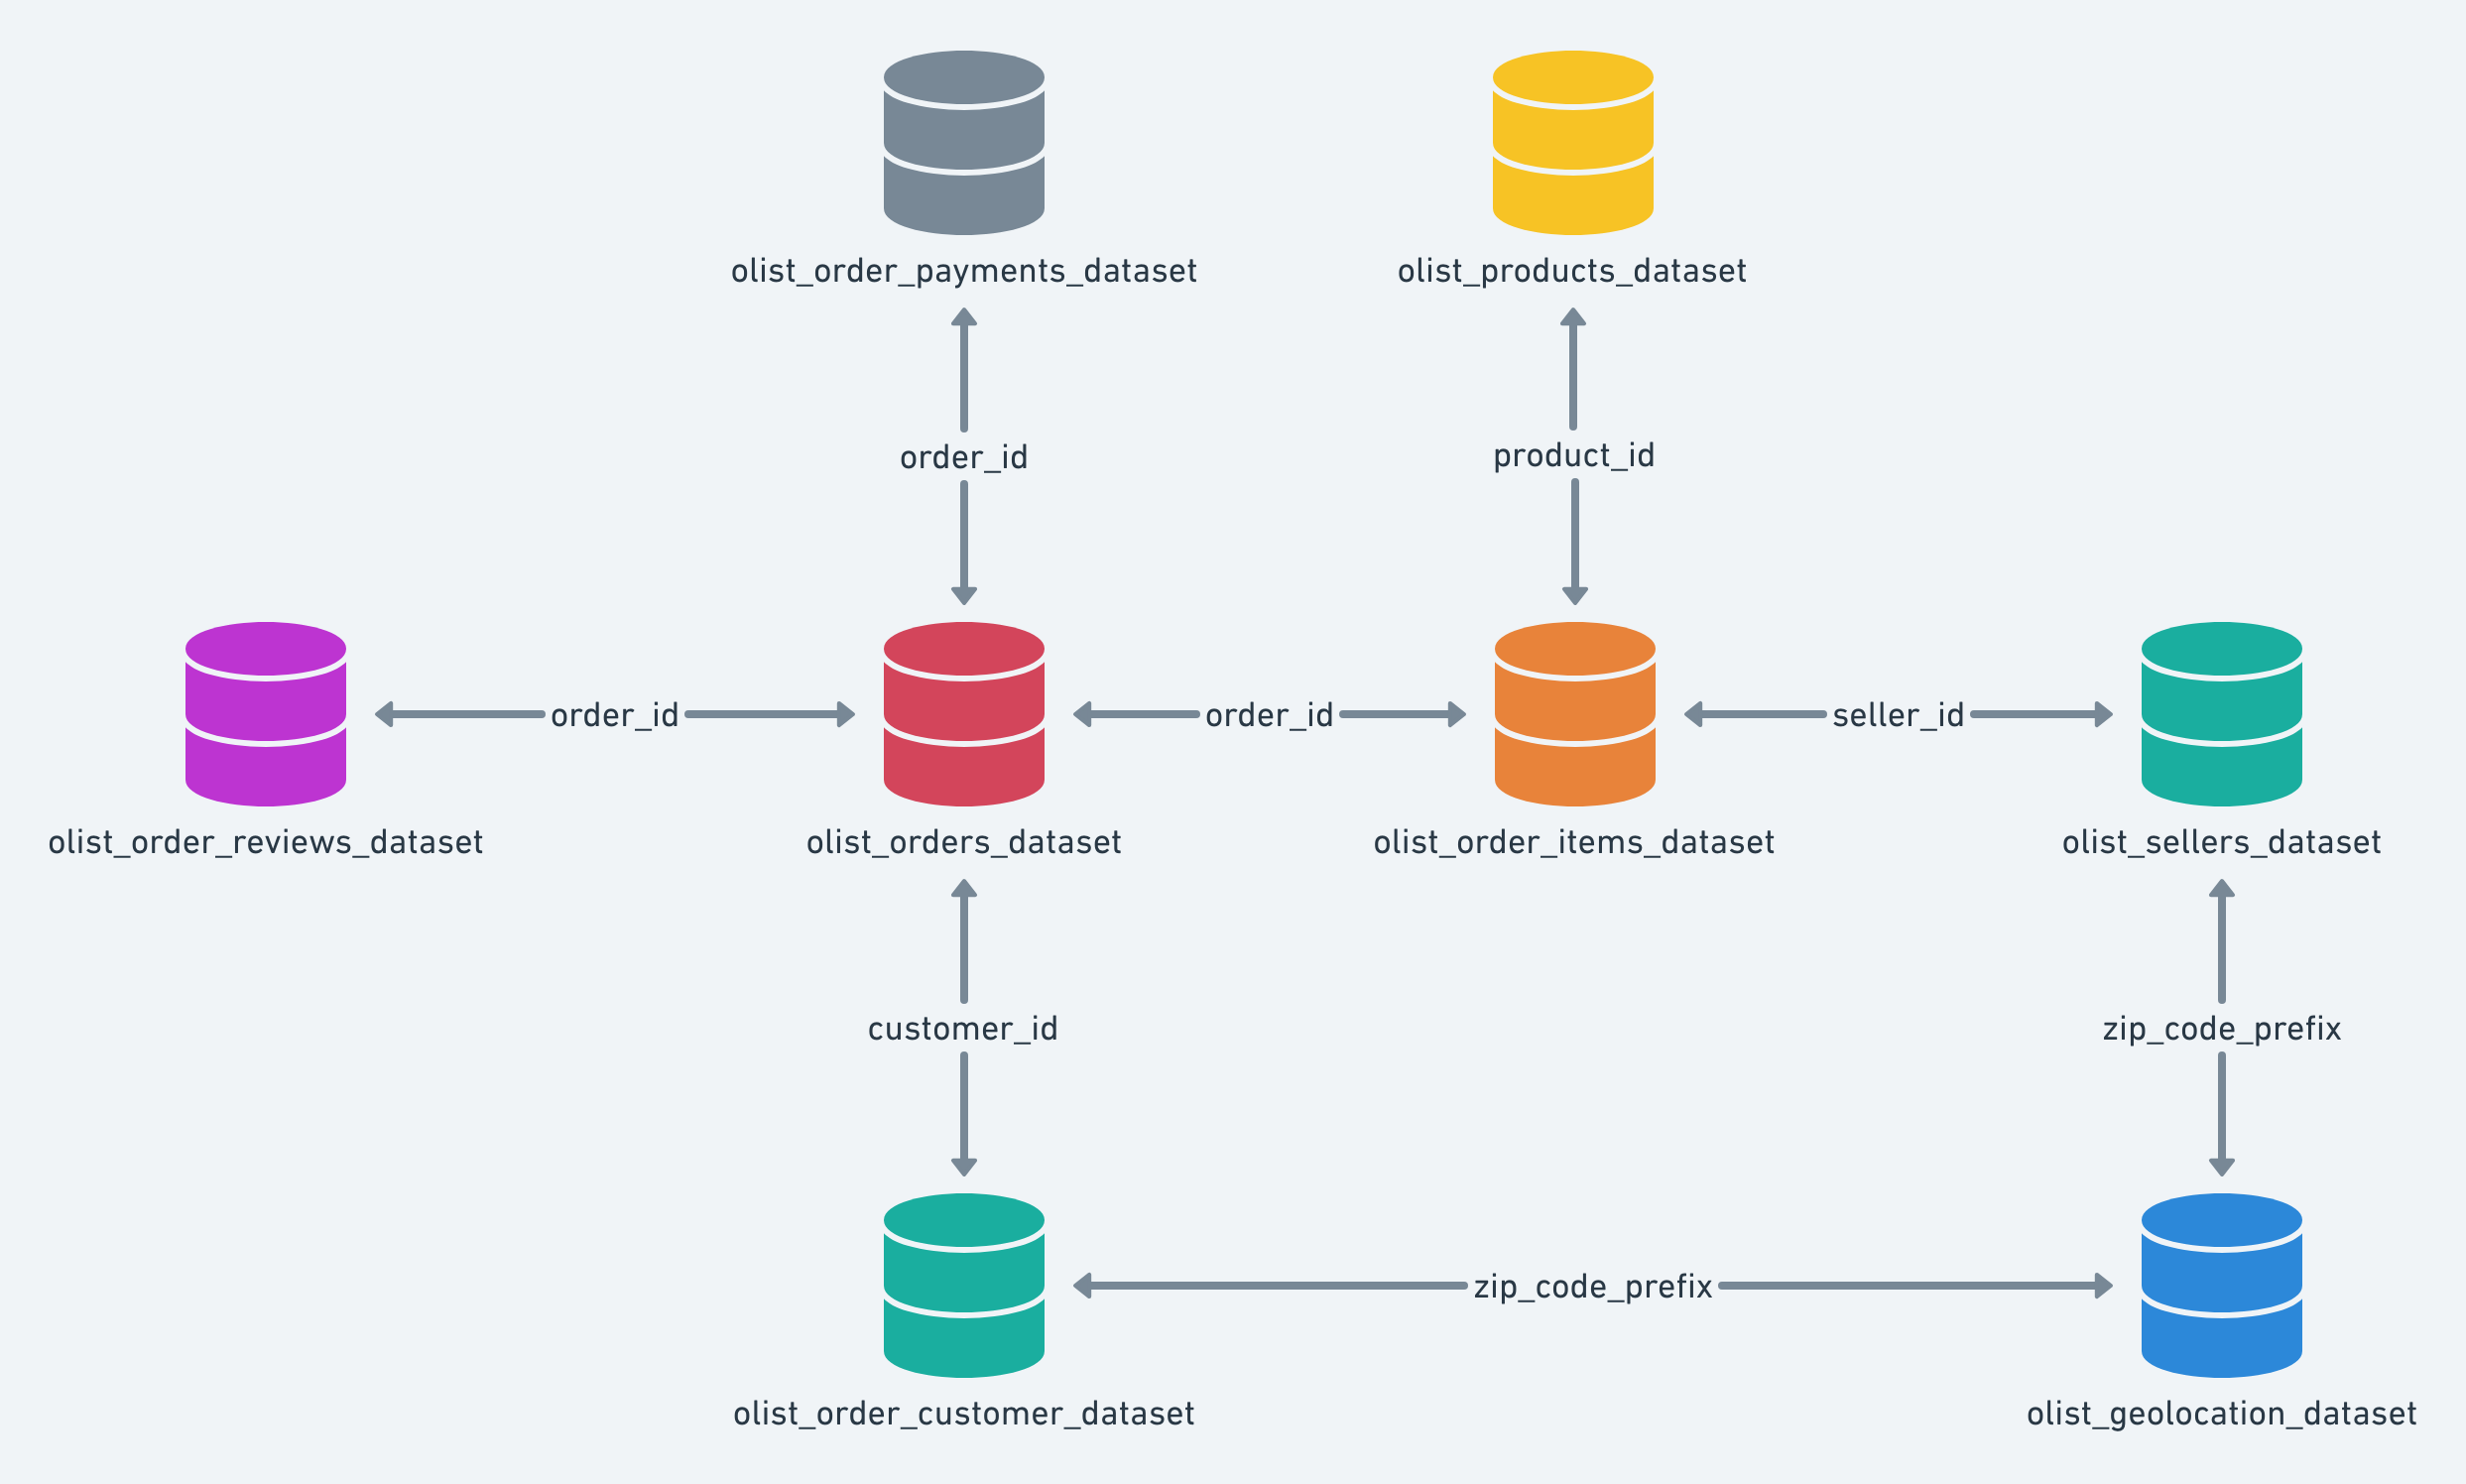

In [7]:
# Carregamento de todos datasets
dtCustomers = pd.read_csv('../data/olist_customers_dataset.csv', encoding = 'utf8')
dtGeolocation = pd.read_csv('../data/olist_geolocation_dataset.csv', encoding = 'utf8')
dtOrderItems = pd.read_csv('../data/olist_order_items_dataset.csv', encoding = 'utf8')
dtOrderPayments = pd.read_csv('../data/olist_order_payments_dataset.csv', encoding = 'utf8')
dtOrderReviews = pd.read_csv('../data/olist_order_reviews_dataset.csv', encoding = 'utf8')
dtOrders = pd.read_csv('../data/olist_orders_dataset.csv', encoding = 'utf8')
dtProducts = pd.read_csv('../data/olist_products_dataset.csv', encoding = 'utf8')
dtSellers = pd.read_csv('../data/olist_sellers_dataset.csv', encoding = 'utf8')

# 2. Analise Exploratória

# 2.1 Como as vendas foram afetadas entre 2016 e 2018? 

Para isso iremos fazer um grafico de analise temporal ao longo dos pedidos aprovados.

In [8]:
# Dataset de pedidos
dtOrders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [9]:
dtOrders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [10]:
# Colunas do tipo data
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
               'order_delivered_customer_date', 'order_estimated_delivery_date']

# Dataset de analise temporal
dtOrdersAjustado = dtOrders.copy()

In [11]:
# Convertendo columas de data para date
for col in dateColumns:
    dtOrdersAjustado[col] = pd.to_datetime(dtOrdersAjustado[col], format = '%Y-%m-%d %H:%M:%S')

In [12]:
dtOrdersAjustado.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [13]:
dtOrdersAjustado.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [14]:
# Verificando tipos unicos
print(dtOrdersAjustado.nunique())

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64


In [15]:
# Verificando columas com null
print(dtOrdersAjustado.isna().sum())

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


Verificamos que possuem valores NA no dataset. Abaixo iremos verificar que possuem apenas 2980 observações como NA. Por essas representaem um valor pequeno do dataset iremos removelas. 

In [16]:
# Verificando valores NA
dtOrdersAjustado[dtOrdersAjustado.isna().any(axis = 1)]

order_id                       customer_id  \
6      136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44     ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103    0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128    15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
154    6942b8da583c2f9957e990d028607019  52006a9383bf149a4fb24226b173106f   
...                                 ...                               ...   
99283  3a3cddda5a7c27851bd96c3313412840  0b0d6095c5555fe083844281f6b093bb   
99313  e9e64a17afa9653aacf2616d94c005b8  b4cd0522e632e481f8eaf766a2646e86   
99347  a89abace0dcc01eeb267a9660b5ac126  2f0524a7b1b3845a1a57fcf3910c4333   
99348  a69ba794cc7deb415c3e15a0a3877e69  726f0894b5becdf952ea537d5266e543   
99415  5fabc81b6322c8443648e1b21a6fef21  32c9df889d41b0ee8309a5efb6855dcb   

      order_status order_purchase_timestamp   order_approved_at  \
6         invoiced      2017-04-11 12:22:08 2017-04-13 13:25:17   
44         shipped      2018-06-04 16:44:48 2018-06-05 04:31:18   
103       invoiced      2018-08-03 17:44:42 2018-08-07 06:15:14   
128     processing      2017-09-03 14:22:03 2017-09-03 14:30:09   
154        shipped      2018-01-10 11:33:07 2018-01-11 02:32:30   
...            ...                      ...                 ...   
99283     canceled      2018-08-31 16:13:44                 NaT   
99313   processing      2018-01-05 23:07:24 2018-01-09 07:18:05   
99347     canceled      2018-09-06 18:45:47                 NaT   
99348  unavailable      2017-08-23 16:28:04 2017-08-28 15:44:47   
99415  unavailable      2017-10-10 10:50:03 2017-10-14 18:35:57   

      order_delivered_carrier_date order_delivered_customer_date  \
6                              NaT                           NaT   
44             2018-06-05 14:32:00                           NaT   
103                            NaT                           NaT   
128                            NaT                           NaT   
154            2018-01-11 19:39:23                           NaT   
...                            ...                           ...   
99283                          NaT                           NaT   
99313                          NaT                           NaT   
99347                          NaT                           NaT   
99348                          NaT                           NaT   
99415                          NaT                           NaT   

      order_estimated_delivery_date  
6                        2017-05-09  
44                       2018-06-28  
103                      2018-08-21  
128                      2017-10-03  
154                      2018-02-07  
...                             ...  
99283                    2018-10-01  
99313                    2018-02-06  
99347                    2018-09-27  
99348                    2017-09-15  
99415                    2017-10-23  

[2980 rows x 8 columns]

In [17]:
# Dropando valores NA
dtOrdersAjustado = dtOrdersAjustado.dropna()

In [18]:
# Verificando se possuem valores duplicados
print(sum(dtOrdersAjustado.duplicated()))

0


In [19]:
dtOrdersAjustado.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [20]:
dtOrdersMesAno = dtOrdersAjustado.copy()

# Mantendo somente Ano e Mes
for col in dateColumns:
    dtOrdersMesAno[col] = pd.to_datetime(dtOrdersMesAno[col], format = '%Y-%m-%d %H:%M:%S').dt.to_period('M')

In [21]:
dtOrdersMesAno.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered                  2017-10           2017-10   
1    delivered                  2018-07           2018-07   
2    delivered                  2018-08           2018-08   
3    delivered                  2017-11           2017-11   
4    delivered                  2018-02           2018-02   

  order_delivered_carrier_date order_delivered_customer_date  \
0                      2017-10                       2017-10   
1                      2018-07                       2018-08   
2                      2018-08                       2018-08   
3                      2017-11                       2017-12   
4                      2018-02                       2018-02   

  order_estimated_delivery_date  
0                       2017-10  
1                       2018-08  
2                       2018-09  
3                       2017-12  
4                       2018-02

Analisando o grafico abaixo é perceptivel que entre 2017 e Janeiro de 2018 tivemos uma alavancagem nas vendas. Estabilizou no inicio de 2018 entre 6 e 7 mil vendas.

In [22]:
dtFiltrado = dtOrdersMesAno.groupby('order_approved_at').count()['order_id'].to_frame().reset_index()

In [23]:
dtFiltrado['order_approved_at'] = dtFiltrado['order_approved_at'].astype(str)

In [24]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = dtFiltrado['order_approved_at'], 
                        y = dtFiltrado['order_id'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Vendas Mensais')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

In [25]:
dtOrdersMesAno.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered                  2017-10           2017-10   
1    delivered                  2018-07           2018-07   
2    delivered                  2018-08           2018-08   
3    delivered                  2017-11           2017-11   
4    delivered                  2018-02           2018-02   

  order_delivered_carrier_date order_delivered_customer_date  \
0                      2017-10                       2017-10   
1                      2018-07                       2018-08   
2                      2018-08                       2018-08   
3                      2017-11                       2017-12   
4                      2018-02                       2018-02   

  order_estimated_delivery_date  
0                       2017-10  
1                       2018-08  
2                       2018-09  
3                       2017-12  
4                       2018-02

In [26]:
dtOrderItems.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [27]:
dtOrderPrice = dtOrderItems.groupby('order_id').agg({'price': sum}).reset_index()

In [28]:
dtOrderPrice.head()

order_id   price
0  00010242fe8c5a6d1ba2dd792cb16214   58.90
1  00018f77f2f0320c557190d7a144bdd3  239.90
2  000229ec398224ef6ca0657da4fc703e  199.00
3  00024acbcdf0a6daa1e931b038114c75   12.99
4  00042b26cf59d7ce69dfabb4e55b4fd9  199.90

In [29]:
dtFaturamentoMesAno = pd.merge(dtOrdersMesAno, dtOrderPrice, on = 'order_id')

In [30]:
dtFaturamentoMesAno.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered                  2017-10           2017-10   
1    delivered                  2018-07           2018-07   
2    delivered                  2018-08           2018-08   
3    delivered                  2017-11           2017-11   
4    delivered                  2018-02           2018-02   

  order_delivered_carrier_date order_delivered_customer_date  \
0                      2017-10                       2017-10   
1                      2018-07                       2018-08   
2                      2018-08                       2018-08   
3                      2017-11                       2017-12   
4                      2018-02                       2018-02   

  order_estimated_delivery_date   price  
0                       2017-10   29.99  
1                       2018-08  118.70  
2                       2018-09  159.90  
3                       2017-12   45.00  
4                       2018-02   19.90

In [31]:
dtFiltrado = dtFaturamentoMesAno.groupby('order_approved_at').agg({'price': sum}).reset_index()

In [32]:
dtFiltrado['order_approved_at'] = dtFiltrado['order_approved_at'].astype(str)

In [33]:
dtFiltrado.head()

order_approved_at      price
0           2016-09     134.97
1           2016-10   40941.30
2           2016-12      10.90
3           2017-01  106888.10
4           2017-02  234163.38

In [34]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = dtFiltrado['order_approved_at'], 
                        y = dtFiltrado['price'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Faturamento Mensal')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

In [35]:
# Calculando crescimento Mensal
dtFiltrado['MonthlyGrowth'] = dtFiltrado['price'].pct_change()

In [36]:
dtFiltrado

order_approved_at      price  MonthlyGrowth
0            2016-09     134.97            NaN
1            2016-10   40941.30     302.336297
2            2016-12      10.90      -0.999734
3            2017-01  106888.10    9805.247706
4            2017-02  234163.38       1.190734
5            2017-03  355372.21       0.517625
6            2017-04  338207.85      -0.048300
7            2017-05  490517.21       0.450342
8            2017-06  425825.55      -0.131885
9            2017-07  476556.89       0.119136
10           2017-08  555061.46       0.164733
11           2017-09  597061.93       0.075668
12           2017-10  652987.87       0.093669
13           2017-11  972486.88       0.489288
14           2017-12  747390.69      -0.231465
15           2018-01  917667.20       0.227828
16           2018-02  819385.26      -0.107100
17           2018-03  963604.25       0.176009
18           2018-04  953526.94      -0.010458
19           2018-05  999867.28       0.048599
20           2018-06  859396.90      -0.140489
21           2018-07  849351.12      -0.011689
22           2018-08  862639.54       0.015645

In [37]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtFiltrado.query("order_approved_at > '2017-01'")['order_approved_at'],
                        y = dtFiltrado.query("order_approved_at > '2017-01'")['MonthlyGrowth'])]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Taxa Percentual de Crescimento Mensal')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig) 

## 2.2.1 Existe diferença significativa de venda para cada um dos meses?

Conforme a analise abaixo é perceptivel que ao longo do ano de 2017, apesar de possuirem algumas oscilações, as vendas se mantiveram crescentes. Conforme se aproxima das datas festivas no mes de dezembro (12) as vendas tendem a crescer com maior intensidade. Porém, apesar da analise inicial, não é possível afirmar que os meses tem impacto em relação as vendas, para isso precisariamos de um historico maior de vendas ao longo de mais anos.

Além disso, seria necessário realizar testes estatisticos que nao serão realizadas devido a falta de necessidade na base atual.

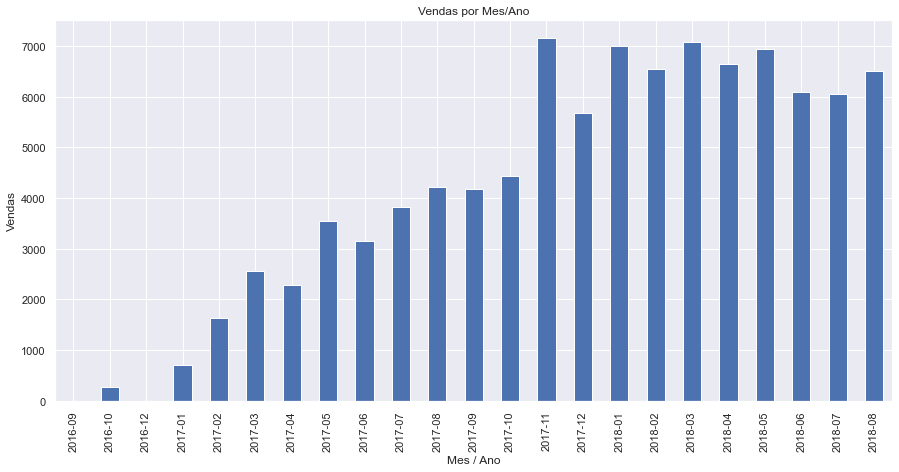

In [38]:
plt.figure(figsize = (15, 7))
dtOrdersMesAno.groupby('order_approved_at').count()['order_id'].plot(kind = 'bar')

plt.xlabel('Mes / Ano')
plt.ylabel('Vendas')
plt.title('Vendas por Mes/Ano')

plt.show()

## 2.2.2 Existe diferença significativa de venda para cada um dos dias da semana?

In [39]:
# Criando copia dataset ajustado
dtOrdersMesAnoDia = dtOrdersAjustado[['order_id', 'order_approved_at']].copy()

In [40]:
dtOrdersMesAnoDia['weekday'] = dtOrdersMesAnoDia['order_approved_at'].dt.dayofweek

In [41]:
dtOrdersMesAnoDia.head()

order_id   order_approved_at  weekday
0  e481f51cbdc54678b7cc49136f2d6af7 2017-10-02 11:07:15        0
1  53cdb2fc8bc7dce0b6741e2150273451 2018-07-26 03:24:27        3
2  47770eb9100c2d0c44946d9cf07ec65d 2018-08-08 08:55:23        2
3  949d5b44dbf5de918fe9c16f97b45f8a 2017-11-18 19:45:59        5
4  ad21c59c0840e6cb83a9ceb5573f8159 2018-02-13 22:20:29        1

In [42]:
# Mantendo somente Ano, Mes e Dia
dtOrdersMesAnoDia['order_approved_at'] = pd.to_datetime(dtOrdersMesAnoDia['order_approved_at'],\
                                                        format = '%Y-%m-%d %H:%M:%S').dt.to_period('y')

In [43]:
dtOrdersMesAnoDia.head()

order_id order_approved_at  weekday
0  e481f51cbdc54678b7cc49136f2d6af7              2017        0
1  53cdb2fc8bc7dce0b6741e2150273451              2018        3
2  47770eb9100c2d0c44946d9cf07ec65d              2018        2
3  949d5b44dbf5de918fe9c16f97b45f8a              2017        5
4  ad21c59c0840e6cb83a9ceb5573f8159              2018        1

In [44]:
dtFiltrado = dtOrdersMesAnoDia.groupby('weekday').count()['order_id'].reset_index()

In [45]:
# Plot

# Definição dos dados no plot
labels = ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sabado']
plot_data = [go.Bar(x = labels, 
                    y = dtFiltrado['order_id'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Total de Vendas por Dia da Semana')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

In [46]:
dtOrdersMesAnoDia2016 = dtOrdersMesAnoDia[dtOrdersMesAnoDia['order_approved_at'] == '2016'].groupby('weekday').\
count()['order_id']
dtOrdersMesAnoDia2017 = dtOrdersMesAnoDia[dtOrdersMesAnoDia['order_approved_at'] == '2017'].groupby('weekday').\
count()['order_id']
dtOrdersMesAnoDia2018 = dtOrdersMesAnoDia[dtOrdersMesAnoDia['order_approved_at'] == '2018'].groupby('weekday').\
count()['order_id']

In [47]:
dtOrdersMesAnoDiaAgrupado = dtOrdersMesAnoDia.groupby(['order_approved_at', 'weekday']).count().reset_index()

In [48]:
dtOrdersMesAnoDiaAgrupado.columns = ['year', 'weekday', 'orders']

In [49]:
dtOrdersMesAnoDiaAgrupado['year'] = dtOrdersMesAnoDiaAgrupado['year'].astype(str)

In [50]:
dtOrdersMesAnoDiaAgrupado

year  weekday  orders
0   2016        0      40
1   2016        1      44
2   2016        2      11
3   2016        3      97
4   2016        4      48
5   2016        5      23
6   2016        6       9
7   2017        0    5285
8   2017        1    8096
9   2017        2    6971
10  2017        3    6399
11  2017        4    6582
12  2017        5    5709
13  2017        6    4312
14  2018        0    7290
15  2018        1   10504
16  2018        2    8348
17  2018        3    8549
18  2018        4    7588
19  2018        5    6104
20  2018        6    4452

In [51]:
dtOrdersMesAnoDiaPivot = dtOrdersMesAnoDiaAgrupado.pivot(index = 'weekday', columns = 'year')['orders'].reset_index()

In [52]:
dtOrdersMesAnoDiaPivot['weekday'] = dtOrdersMesAnoDiaPivot['weekday'].astype(str)

In [53]:
labels_ = {'0': 'Domingo', '1': 'Segunda', '2': 'Terça', '3': 'Quarta', '4': 'Quinta', '5': 'Sexta', '6': 'Sabado'}

In [54]:
dtOrdersMesAnoDiaPivot = dtOrdersMesAnoDiaPivot.replace({'weekday': labels_})

In [55]:
dtOrdersMesAnoDiaPivot

year  weekday  2016  2017   2018
0     Domingo    40  5285   7290
1     Segunda    44  8096  10504
2       Terça    11  6971   8348
3      Quarta    97  6399   8549
4      Quinta    48  6582   7588
5       Sexta    23  5709   6104
6      Sabado     9  4312   4452

In [56]:
fig = px.bar(dtOrdersMesAnoDiaPivot,\
             x = "weekday", y = ['2016', '2017', '2018'], title = "Total de Vendas por Dia da Semana por Ano")
fig.show()

In [57]:
# Criando copia para novo dataset
dtOrdersDiaMesAno = dtOrdersAjustado[['order_id', 'order_approved_at']].copy()

# Mantendo somente Ano, Mes e Dia
dtOrdersDiaMesAno['Data'] = \
    pd.to_datetime(dtOrdersDiaMesAno['order_approved_at'], format = '%Y-%m-%d %H:%M:%S').dt.to_period('d')

In [58]:
# Criandop coluna de Ano
dtOrdersDiaMesAno['Ano'] = \
    pd.to_datetime(dtOrdersDiaMesAno['order_approved_at'], format = '%Y-%m-%d %H:%M:%S').dt.to_period('y')

In [59]:
# Criando coluna de weekday
dtOrdersDiaMesAno['weekday'] = dtOrdersDiaMesAno['order_approved_at'].dt.dayofweek

In [60]:
dtOrdersDiaMesAno.head()

order_id   order_approved_at        Data   Ano  \
0  e481f51cbdc54678b7cc49136f2d6af7 2017-10-02 11:07:15  2017-10-02  2017   
1  53cdb2fc8bc7dce0b6741e2150273451 2018-07-26 03:24:27  2018-07-26  2018   
2  47770eb9100c2d0c44946d9cf07ec65d 2018-08-08 08:55:23  2018-08-08  2018   
3  949d5b44dbf5de918fe9c16f97b45f8a 2017-11-18 19:45:59  2017-11-18  2017   
4  ad21c59c0840e6cb83a9ceb5573f8159 2018-02-13 22:20:29  2018-02-13  2018   

   weekday  
0        0  
1        3  
2        2  
3        5  
4        1

In [61]:
def cria_media_semanal_por_ano(data, ano):
    dtAnoDia = data[data['Ano'] == ano].groupby('weekday').nunique()
    dtAnoDia['mean_orders'] = dtAnoDia.apply(lambda x: int(x['order_id'] / x['Data']), axis = 1)
    dtAnoDia = dtAnoDia['mean_orders'].reset_index()
    dtAnoDia['year'] = ano
    dtAnoDia = dtAnoDia.pivot(index = 'weekday', columns = 'year')['mean_orders'].reset_index()
    
    return dtAnoDia

In [62]:
# Calcula media de vendas por dia da semana do ano de 2016
dtOrdersDiaMesAno2016 = cria_media_semanal_por_ano(dtOrdersDiaMesAno, '2016')

In [63]:
# Calcula media de vendas por dia da semana do ano de 2017
dtOrdersDiaMesAno2017 = cria_media_semanal_por_ano(dtOrdersDiaMesAno, '2017')

In [64]:
# Calcula media de vendas por dia da semana  do ano de 2018
dtOrdersDiaMesAno2018 = cria_media_semanal_por_ano(dtOrdersDiaMesAno, '2018')

In [65]:
dtOrdersDiaMesAno2016

year  weekday  2016
0           0    40
1           1    22
2           2     5
3           3    32
4           4    24
5           5    23
6           6     9

In [66]:
# Concatenando coluna de cada ano
dtOrdersDiaMesAnoPivot = dtOrdersDiaMesAno2016.copy()
dtOrdersDiaMesAnoPivot['2017'] = dtOrdersDiaMesAno2017['2017']
dtOrdersDiaMesAnoPivot['2018'] = dtOrdersDiaMesAno2018['2018']

In [67]:
dtOrdersDiaMesAnoPivot['weekday'] = dtOrdersDiaMesAnoPivot['weekday'].astype(str)

In [68]:
dtOrdersDiaMesAnoPivot = dtOrdersDiaMesAnoPivot.replace({'weekday': labels_})

In [69]:
dtOrdersDiaMesAnoPivot

year  weekday  2016  2017  2018
0     Domingo    40   103   214
1     Segunda    22   158   300
2       Terça     5   136   245
3      Quarta    32   123   251
4      Quinta    24   126   223
5       Sexta    23   109   184
6      Sabado     9    82   139

In [70]:
fig = px.bar(dtOrdersDiaMesAnoPivot,\
             x = "weekday", y = ['2016', '2017', '2018'], title = "Media de Vendas por Dia da Semana por Ano")
fig.show()

## 2.2.3 Existe diferença significativa de venda para cada um dos metodos de pagamento?

In [71]:
dtOrderPayments.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [72]:
dtOrderPayments.groupby('payment_type').count()

order_id  payment_sequential  payment_installments  \
payment_type                                                       
boleto           19784               19784                 19784   
credit_card      76795               76795                 76795   
debit_card        1529                1529                  1529   
not_defined          3                   3                     3   
voucher           5775                5775                  5775   

              payment_value  
payment_type                 
boleto                19784  
credit_card           76795  
debit_card             1529  
not_defined               3  
voucher                5775

In [73]:
dtOrderPayments = dtOrderPayments[dtOrderPayments['payment_type'] != 'not_defined']

In [74]:
dtOrderPayments.groupby('payment_type').count()

order_id  payment_sequential  payment_installments  \
payment_type                                                       
boleto           19784               19784                 19784   
credit_card      76795               76795                 76795   
debit_card        1529                1529                  1529   
voucher           5775                5775                  5775   

              payment_value  
payment_type                 
boleto                19784  
credit_card           76795  
debit_card             1529  
voucher                5775

In [75]:
# Definição dos dados no plot
labels = ['Boleto', 'credit_card', 'debit_card', 'voucher']
values = dtOrderPayments.groupby('payment_type').count()['order_id']

plot_data = [go.Pie(labels = labels, values = values)]

# Layout
plot_layout = go.Layout(title = 'Métodos de Pagamentos')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

## 2.2.4 Existe diferença significativa de venda por região?

In [76]:
dtCustomers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [77]:
salesState = dtCustomers.groupby('customer_state')['customer_id'].count()

In [78]:
salesState = salesState.sort_values(ascending = False).reset_index()

In [79]:
salesState.head()

customer_state  customer_id
0             SP        41746
1             RJ        12852
2             MG        11635
3             RS         5466
4             PR         5045

In [80]:
# Plot

# Definição dos dados no plot
plot_data = [go.Bar(x = salesState['customer_state'], 
                    y = salesState['customer_id'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Total de Vendas por Estado')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

In [81]:
salesStatePercent = salesState.copy()

In [82]:
# Calculando porcentagem de cada estado em relação ao total de vendas
salesStatePercent['percent'] = (salesStatePercent['customer_id'] / salesStatePercent['customer_id'].sum()) * 100

In [83]:
salesStatePercent = salesStatePercent.sort_values(ascending = False, by = 'customer_id')

Analisando abaixo é perceptivel que o estado de São Paulo possui o maior numero de vendas disparado, com 40% das vendas, seguido do Rio de Janeiro e Minas Gerais com aproximadamente 13% das vendas.

In [84]:
# Plot

# Definição dos dados no plot
plot_data = [go.Bar(x = salesStatePercent['customer_state'], 
                    y = salesStatePercent['percent'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Total de Vendas por Estado em Porcentagem')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

## 2.2.5 Existe diferença significativa de numero de clientes por região?

In [85]:
customerState = dtCustomers[['customer_unique_id', 'customer_state']].drop_duplicates().copy()

In [86]:
customerState = customerState.groupby('customer_state')['customer_unique_id'].count()

In [87]:
customerState = customerState.sort_values(ascending = False).reset_index()

In [88]:
customerState.head()

customer_state  customer_unique_id
0             SP               40302
1             RJ               12384
2             MG               11259
3             RS                5277
4             PR                4882

In [89]:
# Plot

# Definição dos dados no plot
plot_data = [go.Bar(x = customerState['customer_state'], 
                    y = customerState['customer_unique_id'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Total de Clientes por Estado')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

In [90]:
customerStatePercent = customerState.copy()

In [91]:
# Calculando porcentagem de cada estado em relação ao total de vendas
customerStatePercent['percent'] =\
        (customerStatePercent['customer_unique_id'] / customerStatePercent['customer_unique_id'].sum()) * 100

In [92]:
customerStatePercent = customerStatePercent.sort_values(ascending = False, by = 'percent')

In [93]:
customerStatePercent.head()

customer_state  customer_unique_id    percent
0             SP               40302  41.921861
1             RJ               12384  12.881751
2             MG               11259  11.711534
3             RS                5277   5.489099
4             PR                4882   5.078223

Analisando abaixo é perceptivel que o estado de São Paulo possui o maior numero de clientes disparado, com 40% dos clientes, seguido do Rio de Janeiro e Minas Gerais com aproximadamente 13% das vendas. Após isso é perceptivel que os outros estados passam a possuir no maximo 5% das vendas chegando a alguns possuirem menos de 1%.

In [94]:
# Plot

# Definição dos dados no plot
plot_data = [go.Bar(x = customerStatePercent['customer_state'], 
                    y = customerStatePercent['percent'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Total de Clientes por Estado')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

## 3. Quais produtos e vendas possuem maior numero de vendas?

Foi identificado que não é fornecido o nome do produto vendido, somente a categoria.

In [95]:
dtOrderItems.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [96]:
dtProducts.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [97]:
# Realizando o merge entre as duas tabelas
dtOrderProducts = pd.merge(dtOrderItems, dtProducts, on = 'product_id')

In [98]:
dtOrderProducts.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
3  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
4  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   

   shipping_limit_date  price  freight_value product_category_name  \
0  2017-09-19 09:45:35   58.9          13.29            cool_stuff   
1  2017-07-05 02:44:11   55.9          17.96            cool_stuff   
2  2018-05-23 10:56:25   64.9          18.33            cool_stuff   
3  2017-08-07 18:55:08   58.9          16.17            cool_stuff   
4  2017-08-16 22:05:11   58.9          13.29            cool_stuff   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 58.0                       598.0                 4.0   
1                 58.0                       598.0                 4.0   
2                 58.0                       598.0                 4.0   
3                 58.0                       598.0                 4.0   
4                 58.0                       598.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             650.0               28.0                9.0              14.0  
1             650.0               28.0                9.0              14.0  
2             650.0               28.0                9.0              14.0  
3             650.0               28.0                9.0              14.0  
4             650.0               28.0                9.0              14.0

In [99]:
# Contando o numero de orders (não unicos) e relacionando a categoria
categoryProducts = dtOrderProducts.groupby('product_category_name')['order_id'].count().sort_values(ascending = False)

Analisando o grafico abaixo é perceptivel a disparidade entre as catogiras mais vendidas. Contudo algumas categorias com maiores numeros de vendas aparentam possuir relação entre as mesmas. Como por exemplo 'cama_mesa_banho' e 'beleza_saude'. Também 'moveis_decoracao' e 'utilidades_domesticas'.

In [100]:
categoryProductsTop10 = categoryProducts.head(10).sort_values(ascending = True).reset_index()

In [101]:
categoryProductsTop10

product_category_name  order_id
0              automotivo      4235
1      ferramentas_jardim      4347
2               telefonia      4545
3      relogios_presentes      5991
4   utilidades_domesticas      6964
5  informatica_acessorios      7827
6        moveis_decoracao      8334
7           esporte_lazer      8641
8            beleza_saude      9670
9         cama_mesa_banho     11115

In [102]:
# Plot

# Definição dos dados no plot
plot_data = [go.Bar(y = categoryProductsTop10['product_category_name'], 
                    x = categoryProductsTop10['order_id'], orientation = 'h')]

# Layout
plot_layout = go.Layout(yaxis = {"type": "category"}, 
                        title = 'Top 10 Categorias Mais Vendidas')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

## 4. As notas de review do produto possuem impacto no número de vendas?

In [103]:
dtOrderItems.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [104]:
dtOrderReviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [105]:
reviewsOrders = pd.merge(dtOrderItems, dtOrderReviews, on = 'order_id')

In [106]:
reviewsOrders = reviewsOrders[['order_id', 'product_id', 'review_score']]

In [107]:
reviewsOrders = reviewsOrders.dropna()

In [108]:
reviewsOrders.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

   review_score  
0             5  
1             4  
2             5  
3             4  
4             5

In [109]:
pedidosProduto = reviewsOrders.groupby('product_id')['order_id'].count().sort_values(ascending = False)

In [110]:
pedidosProduto.head()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    491
422879e10f46682990de24d770e7f83d    487
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    391
Name: order_id, dtype: int64

In [111]:
scoreProduto = reviewsOrders.groupby('product_id')['review_score'].mean().sort_values(ascending = False)

In [112]:
scoreProduto.head()

product_id
00066f42aeeb9f3007548bb9d3f33c38    5.0
86743ff92eee3d16b7df59cddd583b8c    5.0
868ceb027ab706a4dee42e2220006b85    5.0
868969d3a93aeeab7bfcd4fc3d3d65de    5.0
868766ed2172644fdd977d6bd395a107    5.0
Name: review_score, dtype: float64

In [113]:
scoreOrders = scoreProduto.copy()

In [114]:
scoreOrders = scoreOrders.to_frame()

In [115]:
scoreOrders = pd.merge(scoreProduto, pedidosProduto, on = 'product_id')

In [116]:
scoreOrders.head()

review_score  order_id
product_id                                              
00066f42aeeb9f3007548bb9d3f33c38           5.0         1
86743ff92eee3d16b7df59cddd583b8c           5.0         1
868ceb027ab706a4dee42e2220006b85           5.0         1
868969d3a93aeeab7bfcd4fc3d3d65de           5.0         1
868766ed2172644fdd977d6bd395a107           5.0         1

In [117]:
scoreOrders.columns = ['score_medio', 'numero_pedidos']

In [118]:
scoreOrders.head()

score_medio  numero_pedidos
product_id                                                   
00066f42aeeb9f3007548bb9d3f33c38          5.0               1
86743ff92eee3d16b7df59cddd583b8c          5.0               1
868ceb027ab706a4dee42e2220006b85          5.0               1
868969d3a93aeeab7bfcd4fc3d3d65de          5.0               1
868766ed2172644fdd977d6bd395a107          5.0               1

In [119]:
scoreOrders['score_medio'] = round(scoreOrders['score_medio'])

In [120]:
scoreOrders.sort_values(ascending = False, by = 'numero_pedidos').head()

score_medio  numero_pedidos
product_id                                                   
aca2eb7d00ea1a7b8ebd4e68314663af          4.0             527
99a4788cb24856965c36a24e339b6058          4.0             491
422879e10f46682990de24d770e7f83d          4.0             487
389d119b48cf3043d311335e499d9c6b          4.0             392
368c6c730842d78016ad823897a372db          4.0             391

In [121]:
meanScoreOrders = scoreOrders.groupby('score_medio')['numero_pedidos'].sum().reset_index()

In [122]:
meanScoreOrders

score_medio  numero_pedidos
0          1.0            3798
1          2.0            3723
2          3.0           12364
3          4.0           62359
4          5.0           31078

In [123]:
# Plot

# Definição dos dados no plot
plot_data = [go.Bar(x = meanScoreOrders['score_medio'], 
                    y = meanScoreOrders['numero_pedidos'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Vendas por Score (Score Medio por Produto)')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

## 4.1 WordCloud de Reviews

In [124]:
dtOrderReviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [125]:
dtOrderReviews = dtOrderReviews['review_comment_message']

In [126]:
dtOrderReviews = dtOrderReviews.dropna()

In [127]:
dtOrderReviews.head()

3                 Recebi bem antes do prazo estipulado.
4     Parabéns lojas lannister adorei comprar pela I...
9     aparelho eficiente. no site a marca do aparelh...
12      Mas um pouco ,travando...pelo valor ta Boa.\r\n
15    Vendedor confiável, produto ok e entrega antes...
Name: review_comment_message, dtype: object

In [128]:
def limpar_texto(text):
    # Convertendo para str
    text = str(text)
    
    # Remover caracteres non-ascii
    text = ''.join(caracter for caracter in text if ord(caracter) < 128)
    
    # Convertendo para lower case
    text = text.lower()
    
    # Removendo pontuação por expressão regular
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    text = regex.sub(' ', str(text))
    
    # Carregando stopwords em Inglês
    portuguese_stops = set(stopwords.words('portuguese'))
    
    # Removendo stopwords em Inglês
    # Mantendo somente palavras que não são consideradas stopwords
    text = ' '.join(palavra for palavra in text.split() if palavra not in portuguese_stops)
    
    # Criando a estrutura baseada em uma wordnet para lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()    
    # Aplicando Lemmatization
    text = ' '.join(wordnet_lemmatizer.lemmatize(palavra) for palavra in text.split())
    
    return text

In [129]:
dtOrderReviews = dtOrderReviews.to_frame()

In [130]:
dtOrderReviewsTratado = dtOrderReviews.copy()

In [131]:
%%time
print('Tratanto texto...')
dtOrderReviewsTratado['review_comment_message'] = dtOrderReviews['review_comment_message'].map(limpar_texto)
print('Texto tratado')

Tratanto texto...
Texto tratado
Wall time: 10.7 s


In [132]:
dtOrderReviewsTratado.head()

review_comment_message
3                    recebi bem ante prazo estipulado
4   parabns lojas lannister adorei comprar interne...
9   aparelho eficiente site marca aparelho impress...
12                        pouco travando valor ta boa
15    vendedor confivel produto ok entrega ante prazo

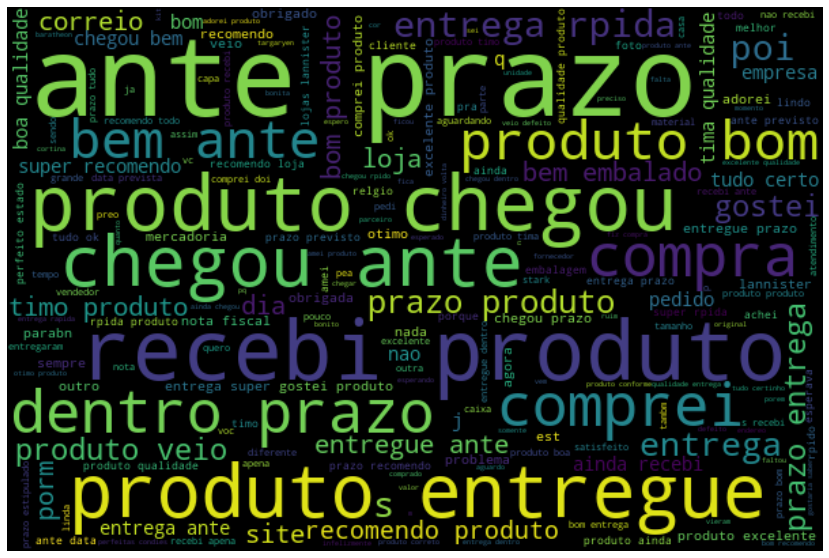

In [133]:
wordcloud = WordCloud(width = 600, height = 400).generate_from_text(\
                                                                ' '.join(dtOrderReviewsTratado['review_comment_message']))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 5. A localização impacta no tempo de entrega?

Por motivos de tempo para desenvolvimento, foi optado por realizar uma estimativa em mapa de calor de quantas vendas são realizas por micro região.

In [134]:
dtGeolocation.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [135]:
latIng = dtGeolocation[['geolocation_lat', 'geolocation_lng']]

In [136]:
latIng.head()

geolocation_lat  geolocation_lng
0       -23.545621       -46.639292
1       -23.546081       -46.644820
2       -23.546129       -46.642951
3       -23.544392       -46.639499
4       -23.541578       -46.641607

In [137]:
geolocator = Nominatim(user_agent = 'Brazilian E-commerce Olist')

In [138]:
mapa = folium.Map([48, 5], tiles = 'stamentoner', zoom_start = 6)

In [139]:
HeatMap(latIng).add_to(mapa)

In [140]:
mapa.save('mapa.html')

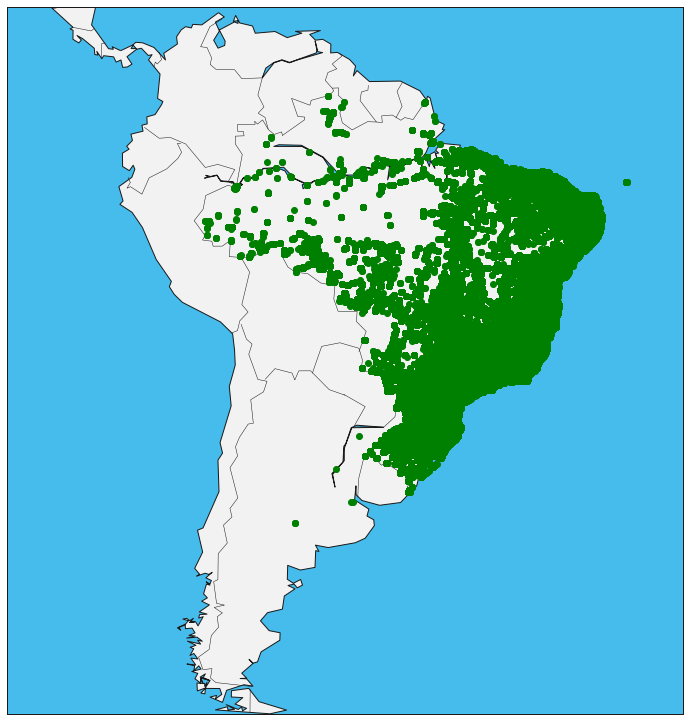

In [141]:
plt.figure(figsize=(13, 13))
mapBrazil = Basemap (llcrnrlat = -55, llcrnrlon = -92, urcrnrlat = 13, urcrnrlon = -27)
mapBrazil.bluemarble()
mapBrazil.drawmapboundary(fill_color = '#46bcec') 
mapBrazil.fillcontinents(color = '#f2f2f2',lake_color = '#46bcec') 
mapBrazil.drawcoastlines()
mapBrazil.drawcountries()
mapBrazil.scatter(dtGeolocation['geolocation_lng'], dtGeolocation['geolocation_lat'],
                  zorder = 10, alpha = 1, color = 'green')
mapBrazil

# 6. O tempo de entrega impacta no review do produto?

In [142]:
dtOrders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [143]:
reviewsOrders.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

   review_score  
0             5  
1             4  
2             5  
3             4  
4             5

In [144]:
reviewOrdersTime = pd.merge(reviewsOrders, dtOrders, on = 'order_id')

In [145]:
reviewOrdersTime = reviewOrdersTime[reviewOrdersTime['order_status'] == 'delivered']

In [146]:
reviewOrdersTime = reviewOrdersTime[['order_id', 'product_id', 'review_score', 'order_delivered_carrier_date',\
                                     'order_delivered_customer_date', 'order_estimated_delivery_date']]

In [147]:
reviewOrdersTime.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

   review_score order_delivered_carrier_date order_delivered_customer_date  \
0             5          2017-09-19 18:34:16           2017-09-20 23:43:48   
1             4          2017-05-04 14:35:00           2017-05-12 16:04:24   
2             5          2018-01-16 12:36:48           2018-01-22 13:19:16   
3             4          2018-08-10 13:28:00           2018-08-14 13:32:39   
4             5          2017-02-16 09:46:09           2017-03-01 16:42:31   

  order_estimated_delivery_date  
0           2017-09-29 00:00:00  
1           2017-05-15 00:00:00  
2           2018-02-05 00:00:00  
3           2018-08-20 00:00:00  
4           2017-03-17 00:00:00

In [148]:
# Mantendo somente Ano, Mes e Dia
reviewOrdersTime['order_delivered_carrier_date'] = \
    pd.to_datetime(reviewOrdersTime['order_delivered_carrier_date'], format = '%Y-%m-%d %H:%M:%S').dt.to_period('d')

In [149]:
# Mantendo somente Ano, Mes e Dia
reviewOrdersTime['order_delivered_customer_date'] = \
    pd.to_datetime(reviewOrdersTime['order_delivered_customer_date'], format = '%Y-%m-%d %H:%M:%S').dt.to_period('d')

In [150]:
# Mantendo somente Ano, Mes e Dia
reviewOrdersTime['order_estimated_delivery_date'] = \
    pd.to_datetime(reviewOrdersTime['order_estimated_delivery_date'], format = '%Y-%m-%d %H:%M:%S').dt.to_period('d')

In [151]:
reviewOrdersTime.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

   review_score order_delivered_carrier_date order_delivered_customer_date  \
0             5                   2017-09-19                    2017-09-20   
1             4                   2017-05-04                    2017-05-12   
2             5                   2018-01-16                    2018-01-22   
3             4                   2018-08-10                    2018-08-14   
4             5                   2017-02-16                    2017-03-01   

  order_estimated_delivery_date  
0                    2017-09-29  
1                    2017-05-15  
2                    2018-02-05  
3                    2018-08-20  
4                    2017-03-17

In [152]:
reviewOrdersTime.dtypes

order_id                            object
product_id                          object
review_score                         int64
order_delivered_carrier_date     period[D]
order_delivered_customer_date    period[D]
order_estimated_delivery_date    period[D]
dtype: object

In [153]:
print(reviewOrdersTime.isna().sum())

order_id                         0
product_id                       0
review_score                     0
order_delivered_carrier_date     2
order_delivered_customer_date    8
order_estimated_delivery_date    0
dtype: int64


In [154]:
reviewOrdersTime = reviewOrdersTime.dropna()

In [155]:
print(reviewOrdersTime.shape)

(110839, 6)


In [156]:
reviewOrdersTime['diff_delivery_and_estimate'] = reviewOrdersTime['order_estimated_delivery_date'] -\
                                           reviewOrdersTime['order_delivered_customer_date']

In [157]:
reviewOrdersTime['diff_delivery_and_estimate'] = \
                reviewOrdersTime['diff_delivery_and_estimate'].apply(lambda x: re.sub("[^0-9]", "", str(x)))

In [158]:
reviewOrdersTime['diff_delivery_and_estimate'] = pd.to_numeric(reviewOrdersTime['diff_delivery_and_estimate'])

In [159]:
reviewOrdersTime.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

   review_score order_delivered_carrier_date order_delivered_customer_date  \
0             5                   2017-09-19                    2017-09-20   
1             4                   2017-05-04                    2017-05-12   
2             5                   2018-01-16                    2018-01-22   
3             4                   2018-08-10                    2018-08-14   
4             5                   2017-02-16                    2017-03-01   

  order_estimated_delivery_date  diff_delivery_and_estimate  
0                    2017-09-29                         9.0  
1                    2017-05-15                         3.0  
2                    2018-02-05                        14.0  
3                    2018-08-20                         6.0  
4                    2017-03-17                        16.0

In [160]:
reviewOrdersTime.dtypes

order_id                            object
product_id                          object
review_score                         int64
order_delivered_carrier_date     period[D]
order_delivered_customer_date    period[D]
order_estimated_delivery_date    period[D]
diff_delivery_and_estimate         float64
dtype: object

Não possuem atrasos.

In [161]:
reviewOrdersTime[reviewOrdersTime['diff_delivery_and_estimate'] < 0]

Empty DataFrame
Columns: [order_id, product_id, review_score, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, diff_delivery_and_estimate]
Index: []

In [162]:
reviewOrdersTime[reviewOrdersTime['diff_delivery_and_estimate'] <= 0]

order_id                        product_id  \
8       0005a1a1728c9d785b8e2b08b904576c  310ae3c140ff94b03219ad0adc3c778f   
11      00063b381e2406b52ad429470734ebd5  f177554ea93259a5b282f24e33f65ab6   
101     00378c6c981f234634c0b9d6128df6dd  38fa750a3a3b3204f169c86a3284d387   
231     0097f0545a302aafa32782f1734ff71c  b6397895a17ce86decd60b898b459796   
232     0097f0545a302aafa32782f1734ff71c  636598095d69a5718e67d2c9a3c7dde6   
...                                  ...                               ...   
112731  fe97f3949cbc37b9ab48ac5769514cbe  40a1e3c65a0bcf6f4ebba840a8156ba2   
112904  fefbe15ebcd87ab3fb8577e635a8b31c  380db7678ce8fd2e3c80de130bc32fbd   
113075  ff65c06d9d1fcec5dfefe1dbeb606e5f  1d6b1ff2a0ef2336832512132b3af6aa   
113153  ff9c2c99255c1843bf2fa114e7e35569  4ebb87ba41ca446326804d0e7f8dcc93   
113282  ffea406a848c8afe4dec22bf6290ba00  801a695ff5c0c14970a71a4ceb70989e   

        review_score order_delivered_carrier_date  \
8                  1                   2018-03-28   
11                 5                   2018-07-30   
101                4                   2018-02-05   
231                1                   2018-03-06   
232                1                   2018-03-06   
...              ...                          ...   
112731             1                   2017-11-30   
112904             5                   2018-03-19   
113075             5                   2017-11-07   
113153             2                   2017-04-18   
113282             1                   2017-03-16   

       order_delivered_customer_date order_estimated_delivery_date  \
8                         2018-03-29                    2018-03-29   
11                        2018-08-07                    2018-08-07   
101                       2018-02-26                    2018-02-26   
231                       2018-03-21                    2018-03-21   
232                       2018-03-21                    2018-03-21   
...                              ...                           ...   
112731                    2017-12-18                    2017-12-18   
112904                    2018-03-20                    2018-03-20   
113075                    2017-12-01                    2017-12-01   
113153                    2017-05-10                    2017-05-10   
113282                    2017-04-05                    2017-04-05   

        diff_delivery_and_estimate  
8                              0.0  
11                             0.0  
101                            0.0  
231                            0.0  
232                            0.0  
...                            ...  
112731                         0.0  
112904                         0.0  
113075                         0.0  
113153                         0.0  
113282                         0.0  

[1462 rows x 7 columns]

In [163]:
COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

In [164]:
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

In [165]:
reviewOrdersTime['order_delivered_customer_date'] = reviewOrdersTime['order_delivered_customer_date'].astype('str')

Visto que não possuem atrasos para os pedidos, é notado que não possui um padrão claro wem relação ao tempo de entrega versus o review.

In [166]:
reviewOrdersTime

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
113317  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
113318  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
113319  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
113320  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
113321  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

        review_score order_delivered_carrier_date  \
0                  5                   2017-09-19   
1                  4                   2017-05-04   
2                  5                   2018-01-16   
3                  4                   2018-08-10   
4                  5                   2017-02-16   
...              ...                          ...   
113317             5                   2018-04-25   
113318             5                   2018-07-17   
113319             5                   2017-10-26   
113320             5                   2017-08-15   
113321             5                   2018-06-11   

       order_delivered_customer_date order_estimated_delivery_date  \
0                         2017-09-20                    2017-09-29   
1                         2017-05-12                    2017-05-15   
2                         2018-01-22                    2018-02-05   
3                         2018-08-14                    2018-08-20   
4                         2017-03-01                    2017-03-17   
...                              ...                           ...   
113317                    2018-05-10                    2018-05-18   
113318                    2018-07-23                    2018-08-01   
113319                    2017-10-28                    2017-11-10   
113320                    2017-08-16                    2017-08-25   
113321                    2018-06-14                    2018-06-28   

        diff_delivery_and_estimate  
0                              9.0  
1                              3.0  
2                             14.0  
3                              6.0  
4                             16.0  
...                            ...  
113317                         8.0  
113318                         9.0  
113319                        13.0  
113320                         9.0  
113321                        14.0  

[110839 rows x 7 columns]

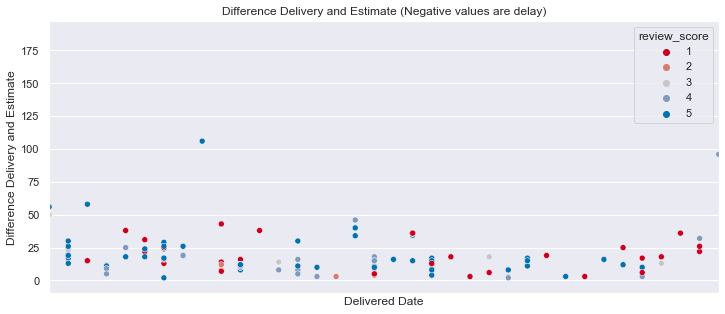

In [167]:
sns.scatterplot(x = 'order_delivered_customer_date', y = 'diff_delivery_and_estimate',
               hue = 'review_score',
               palette = REVIEWS_PALETTE,
               data = reviewOrdersTime)
plt.xlabel('Delivered Date')
plt.ylabel('Difference Delivery and Estimate')
plt.title('Difference Delivery and Estimate (Negative values are delay)')
plt.xlim(reviewOrdersTime['order_delivered_customer_date'].min(), reviewOrdersTime['order_delivered_customer_date'].max())
plt.xticks([])
resize_plot()

## 7. Quais categorias são mais consumidas por região?

Para melhor construção e interpretação do grafico iremos determinar que as regiões são iguais aos estados, e para resumirmos os dados iremos utilizar somente os 5 estados com maior representação nos dados conforme visto no indicador 2.2.5 . Também iremos resumir os dados em relação aos produtos, utilizando somente os top 3 ou 5 categorias de cada região.

Estados com maior representatividade em vendas:
1. São Paulo
2. Rio de Janeiro
3. Minas Gerais
4. Rio Grande do Sul
5. Paraná
6. Santa Catarina

In [168]:
customerNotUniqueState = dtCustomers[['customer_id', 'customer_state']].drop_duplicates().copy()

In [169]:
customerNotUniqueState = pd.merge(customerNotUniqueState, dtOrders, on = 'customer_id')

In [170]:
customerNotUniqueState = customerNotUniqueState[['customer_id', 'customer_state', 'order_id']]

In [171]:
customerNotUniqueState = pd.merge(customerNotUniqueState, dtOrderProducts , on = 'order_id')

In [172]:
customerNotUniqueStateFiltered = customerNotUniqueState[['customer_id', 'customer_state', 'order_id', 'product_category_name']]

In [173]:
customerNotUniqueStateFiltered.head()

customer_id customer_state  \
0  06b8999e2fba1a1fbc88172c00ba8bc7             SP   
1  18955e83d337fd6b2def6b18a428ac77             SP   
2  4e7b3e00288586ebd08712fdd0374a03             SP   
3  b2b6027bc5c5109e529d4dc6358b12c3             SP   
4  4f2d8ab171c80ec8364f7c12e35b23ad             SP   

                           order_id  product_category_name  
0  00e7ee1b050b8499577073aeb2a297a1      moveis_escritorio  
1  29150127e6685892b6eab3eec79f59c7  utilidades_domesticas  
2  b2059ed67ce144a36e2aa97d2c9e9ad2      moveis_escritorio  
3  951670f92359f4fe4a63112aa7306eba      moveis_escritorio  
4  6b7d50bd145f6fc7f33cebabd7e49d0f          casa_conforto

In [174]:
customerNotUniqueStateFiltered[customerNotUniqueStateFiltered['customer_state'] == 'SP']['product_category_name'].\
    value_counts().head(5)#.plot(kind = 'barh')

cama_mesa_banho          5235
beleza_saude             4204
esporte_lazer            3667
moveis_decoracao         3531
utilidades_domesticas    3265
Name: product_category_name, dtype: int64

É perceptivel que no estado de São Paulo possui um numero muito maior de vendas em relação a 'Cama_mesa_banho' para os outros produtos. Essa diferença para a mesma categoria se torna maior no estado do RJ.

Já no estado do Paraná as vendas se apresentam maior em 'moveis_decoracao' e em Santa Catarina apesar de o equilibrio das vendas ser proximo, 'esporte_lazer' lidera as vendas. Porém, é perceptivel que as mesmas top categorias tendem a aparecer em todos os estados, porém com proporções diferentes.

In [175]:
states = ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC']
top_category = 5

col_nums = 2
row_nums = 3
row_ = 1
col_ = 1

fig = make_subplots(rows = row_nums, cols = col_nums, shared_yaxes = False, subplot_titles = states,
                   horizontal_spacing = 0.25)

for i, state in enumerate(states, 1):
    dtFiltrado = customerNotUniqueStateFiltered[customerNotUniqueStateFiltered['customer_state'] == states[i - 1]]['product_category_name'].\
    value_counts().head(top_category).reset_index()
    
    fig.add_trace(go.Bar(x = dtFiltrado['product_category_name'],
                         y = dtFiltrado['index'], orientation = 'h'), row = row_, col = col_)
    fig.update_yaxes(showgrid = False, row = row_, col = col_)
    
    col_ += 1
    if col_ > col_nums:
        col_ = 1
        row_ += 1


fig.update_layout(showlegend = False, title_text = "Categorias Mais Vendidas por Estado", height = 700)
fig.show()

## 8. Clientes Ativos por Mês

Clientes ativos são aqueles que fizeram pelo menos uma compra em cada mês.

In [176]:
dtCustomers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [177]:
dtOrders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [178]:
dtCustomersOrders = pd.merge(dtCustomers, dtOrders, on = 'customer_id')

In [179]:
# Mantendo somente Ano e Mes
dtCustomersOrders['order_purchase_timestamp'] =\
        pd.to_datetime(dtCustomersOrders['order_purchase_timestamp'], format = '%Y-%m-%d %H:%M:%S').dt.to_period('M')

In [180]:
dtCustomersOrders = dtCustomersOrders[['order_purchase_timestamp', 'customer_id']]

In [181]:
dtCustomersOrders.columns = ['AnoMes', 'customer_id']

In [182]:
dtCustomersOrders.head()

AnoMes                       customer_id
0  2017-05  06b8999e2fba1a1fbc88172c00ba8bc7
1  2018-01  18955e83d337fd6b2def6b18a428ac77
2  2018-05  4e7b3e00288586ebd08712fdd0374a03
3  2018-03  b2b6027bc5c5109e529d4dc6358b12c3
4  2018-07  4f2d8ab171c80ec8364f7c12e35b23ad

In [183]:
dtActiveCustomers = dtCustomersOrders.groupby('AnoMes')['customer_id'].nunique().reset_index()

In [184]:
dtActiveCustomers['AnoMes'] = dtActiveCustomers['AnoMes'].astype(str)

In [185]:
dtActiveCustomers.head()

AnoMes  customer_id
0  2016-09            4
1  2016-10          324
2  2016-12            1
3  2017-01          800
4  2017-02         1780

É perceptivel qoe o numero de clientes ativos veio por uma crescente no segundo semeste de 2017 até passar a ter suporte em 6 mil clientes ativos no primeiro semestre do ano de 2018.

In [186]:
# Plot

# Definição dos dados no plot
plot_data = [go.Bar(x = dtActiveCustomers['AnoMes'], 
                    y = dtActiveCustomers['customer_id'],)]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Clientes Ativos Por Mês')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

## 9. Taxa de Retenção de Clientes

Vamos considerar cliente novo aquele com baixo volume de compras e cliente antigo aquele com alto volume de compras.

In [187]:
dtCustomersOrders = pd.merge(dtCustomers, dtOrders, on = 'customer_id')

In [188]:
# Mantendo somente Ano e Mes
dtCustomersOrders['order_purchase_timestamp'] =\
        pd.to_datetime(dtCustomersOrders['order_purchase_timestamp'], format = '%Y-%m-%d %H:%M:%S')

In [189]:
dtCustomersOrders['order_purchase_timestamp'] =\
            dtCustomersOrders['order_purchase_timestamp'].map(lambda date: 100 * date.year + date.month)

In [190]:
dtCustomersOrders.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status  order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered                    201705   
1  29150127e6685892b6eab3eec79f59c7    delivered                    201801   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered                    201805   
3  951670f92359f4fe4a63112aa7306eba    delivered                    201803   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered                    201807   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  
0           2017-05-25 10:35:35           2017-06-05 00:00:00  
1           2018-01-29 12:41:19           2018-02-06 00:00:00  
2           2018-06-14 17:58:51           2018-06-13 00:00:00  
3           2018-03-28 16:04:25           2018-04-10 00:00:00  
4           2018-08-09 20:55:48           2018-08-15 00:00:00

In [191]:
dtOrderPrice = dtOrderItems.groupby('order_id').agg({'price': sum}).reset_index()

In [192]:
dtOrderPrice.head()

order_id   price
0  00010242fe8c5a6d1ba2dd792cb16214   58.90
1  00018f77f2f0320c557190d7a144bdd3  239.90
2  000229ec398224ef6ca0657da4fc703e  199.00
3  00024acbcdf0a6daa1e931b038114c75   12.99
4  00042b26cf59d7ce69dfabb4e55b4fd9  199.90

In [193]:
dtCustomersOrders = pd.merge(dtCustomersOrders, dtOrderPrice, on = 'order_id')

In [194]:
dtCustomersOrders.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status  order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered                    201705   
1  29150127e6685892b6eab3eec79f59c7    delivered                    201801   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered                    201805   
3  951670f92359f4fe4a63112aa7306eba    delivered                    201803   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered                    201807   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date   price  
0           2017-05-25 10:35:35           2017-06-05 00:00:00  124.99  
1           2018-01-29 12:41:19           2018-02-06 00:00:00  289.00  
2           2018-06-14 17:58:51           2018-06-13 00:00:00  139.94  
3           2018-03-28 16:04:25           2018-04-10 00:00:00  149.94  
4           2018-08-09 20:55:48           2018-08-15 00:00:00  230.00

In [195]:
dtPurchaseCustomers = dtCustomersOrders.groupby(['customer_unique_id', 'order_purchase_timestamp'])['price'].sum().reset_index()

In [196]:
dtPurchaseCustomers.head()

customer_unique_id  order_purchase_timestamp   price
0  0000366f3b9a7992bf8c76cfdf3221e2                    201805  129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f                    201805   18.90
2  0000f46a3911fa3c0805444483337064                    201703   69.00
3  0000f6ccb0745a6a4b88665a16c9f078                    201710   25.99
4  0004aac84e0df4da2b147fca70cf8255                    201711  180.00

In [197]:
df_ret = pd.crosstab(dtPurchaseCustomers['customer_unique_id'], dtPurchaseCustomers['order_purchase_timestamp']).reset_index()

In [198]:
df_ret.head()

order_purchase_timestamp                customer_unique_id  201609  201610  \
0                         0000366f3b9a7992bf8c76cfdf3221e2       0       0   
1                         0000b849f77a49e4a4ce2b2a4ca5be3f       0       0   
2                         0000f46a3911fa3c0805444483337064       0       0   
3                         0000f6ccb0745a6a4b88665a16c9f078       0       0   
4                         0004aac84e0df4da2b147fca70cf8255       0       0   

order_purchase_timestamp  201612  201701  201702  201703  201704  201705  \
0                              0       0       0       0       0       0   
1                              0       0       0       0       0       0   
2                              0       0       0       1       0       0   
3                              0       0       0       0       0       0   
4                              0       0       0       0       0       0   

order_purchase_timestamp  201706  ...  201712  201801  201802  201803  201804  \
0                              0  ...       0       0       0       0       0   
1                              0  ...       0       0       0       0       0   
2                              0  ...       0       0       0       0       0   
3                              0  ...       0       0       0       0       0   
4                              0  ...       0       0       0       0       0   

order_purchase_timestamp  201805  201806  201807  201808  201809  
0                              1       0       0       0       0  
1                              1       0       0       0       0  
2                              0       0       0       0       0  
3                              0       0       0       0       0  
4                              0       0       0       0       0  

[5 rows x 25 columns]

In [199]:
# Extraímos os meses
meses = df_ret.columns[2:]

In [200]:
meses

Index([201610, 201612, 201701, 201702, 201703, 201704, 201705, 201706, 201707,
       201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804,
       201805, 201806, 201807, 201808, 201809],
      dtype='object', name='order_purchase_timestamp')

In [201]:
# O loop abaixo vai calcular a retenção ao longo dos meses

# Lista para gravar o resulatdo
lista_ret = []

# Loop
for i in range(len(meses)-1):
    dados_retencao = {}
    mes_corrente = meses[i+1]
    mes_anterior = meses[i]
    dados_retencao['AnoMes'] = int(mes_corrente)
    dados_retencao['TotalUser'] = df_ret[mes_corrente].sum()
    dados_retencao['TotalRetido'] = df_ret[(df_ret[mes_corrente] > 0) & (df_ret[mes_anterior] > 0)][mes_corrente].sum()
    lista_ret.append(dados_retencao)
    
lista_ret

[{'AnoMes': 201612, 'TotalUser': 1, 'TotalRetido': 0},
 {'AnoMes': 201701, 'TotalUser': 755, 'TotalRetido': 1},
 {'AnoMes': 201702, 'TotalUser': 1708, 'TotalRetido': 3},
 {'AnoMes': 201703, 'TotalUser': 2601, 'TotalRetido': 4},
 {'AnoMes': 201704, 'TotalUser': 2359, 'TotalRetido': 13},
 {'AnoMes': 201705, 'TotalUser': 3588, 'TotalRetido': 14},
 {'AnoMes': 201706, 'TotalUser': 3154, 'TotalRetido': 17},
 {'AnoMes': 201707, 'TotalUser': 3894, 'TotalRetido': 17},
 {'AnoMes': 201708, 'TotalUser': 4211, 'TotalRetido': 23},
 {'AnoMes': 201709, 'TotalUser': 4170, 'TotalRetido': 32},
 {'AnoMes': 201710, 'TotalUser': 4501, 'TotalRetido': 32},
 {'AnoMes': 201711, 'TotalUser': 7342, 'TotalRetido': 37},
 {'AnoMes': 201712, 'TotalUser': 5557, 'TotalRetido': 41},
 {'AnoMes': 201801, 'TotalUser': 7120, 'TotalRetido': 17},
 {'AnoMes': 201802, 'TotalUser': 6537, 'TotalRetido': 28},
 {'AnoMes': 201803, 'TotalUser': 7096, 'TotalRetido': 26},
 {'AnoMes': 201804, 'TotalUser': 6878, 'TotalRetido': 35},
 {'An

In [202]:
df_ret_final = pd.DataFrame(lista_ret)
df_ret_final.head()

AnoMes  TotalUser  TotalRetido
0  201612          1            0
1  201701        755            1
2  201702       1708            3
3  201703       2601            4
4  201704       2359           13

In [203]:
# Calculamos o indicador
df_ret_final['TaxaRetencao'] = df_ret_final['TotalRetido'] / df_ret_final['TotalUser']
df_ret_final

AnoMes  TotalUser  TotalRetido  TaxaRetencao
0   201612          1            0      0.000000
1   201701        755            1      0.001325
2   201702       1708            3      0.001756
3   201703       2601            4      0.001538
4   201704       2359           13      0.005511
5   201705       3588           14      0.003902
6   201706       3154           17      0.005390
7   201707       3894           17      0.004366
8   201708       4211           23      0.005462
9   201709       4170           32      0.007674
10  201710       4501           32      0.007110
11  201711       7342           37      0.005039
12  201712       5557           41      0.007378
13  201801       7120           17      0.002388
14  201802       6537           28      0.004283
15  201803       7096           26      0.003664
16  201804       6878           35      0.005089
17  201805       6795           45      0.006623
18  201806       6121           39      0.006372
19  201807       6211           26      0.004186
20  201808       6411           37      0.005771
21  201809          1            1      1.000000

Já visualizando a taxa de retenção de clientes é perceptivel que essa é extremamente baixa, sempre abaixo de 1% de retenção. Comparando com os clientes ativos vistos anteriormente, é perceptivel que o E-commerce não está conseguindo manter os clientes antigos, somente gerando clientes novos com possiveis campanhas de marketing.

In [204]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = df_ret_final.query('AnoMes < 201809')['AnoMes'],
                        y = df_ret_final.query('AnoMes < 201809')['TaxaRetencao'],
                        name = "taxa")]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Taxa Mensal de Retenção de Clientes')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

## 10. Faturamento de Clientes Antigos Vs Novos

Vamos considerar cliente novo aquele com baixo volume de compras e cliente antigo aquele com alto volume de compras.

In [234]:
dtCustomersOrders = pd.merge(dtCustomers, dtOrders, on = 'customer_id')

In [235]:
dtCustomersOrders.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  
0           2017-05-25 10:35:35           2017-06-05 00:00:00  
1           2018-01-29 12:41:19           2018-02-06 00:00:00  
2           2018-06-14 17:58:51           2018-06-13 00:00:00  
3           2018-03-28 16:04:25           2018-04-10 00:00:00  
4           2018-08-09 20:55:48           2018-08-15 00:00:00

In [236]:
# Mantendo somente Ano, Mes e Dia
dtCustomersOrders['order_purchase_timestamp'] = pd.to_datetime(dtCustomersOrders['order_purchase_timestamp'],\
                                                        format = '%Y-%m-%d %H:%M:%S')

In [237]:
# Vamos encontrar a data de menor volume de compras de cada cliente
dtMinPurchase = dtCustomersOrders.groupby('customer_unique_id')["order_purchase_timestamp"].min().reset_index()

In [238]:
# Vamos extrair o mês em que ocorreu o menor volume de compras de cada cliente
dtMinPurchase['Mes_Menor_Compra_Mensal'] =\
dtMinPurchase['order_purchase_timestamp'].map(lambda date: 100 * date.year + date.month)

In [239]:
dtMinPurchase.head()

customer_unique_id order_purchase_timestamp  \
0  0000366f3b9a7992bf8c76cfdf3221e2      2018-05-10 10:56:27   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      2018-05-07 11:11:27   
2  0000f46a3911fa3c0805444483337064      2017-03-10 21:05:03   
3  0000f6ccb0745a6a4b88665a16c9f078      2017-10-12 20:29:41   
4  0004aac84e0df4da2b147fca70cf8255      2017-11-14 19:45:42   

   Mes_Menor_Compra_Mensal  
0                   201805  
1                   201805  
2                   201703  
3                   201710  
4                   201711

In [240]:
dtCustomersOrders['order_purchase_timestamp'] =\
dtCustomersOrders['order_purchase_timestamp'].map(lambda date: 100 * date.year + date.month)

In [241]:
dtCustomersOrders.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status  order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered                    201705   
1  29150127e6685892b6eab3eec79f59c7    delivered                    201801   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered                    201805   
3  951670f92359f4fe4a63112aa7306eba    delivered                    201803   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered                    201807   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  
0           2017-05-25 10:35:35           2017-06-05 00:00:00  
1           2018-01-29 12:41:19           2018-02-06 00:00:00  
2           2018-06-14 17:58:51           2018-06-13 00:00:00  
3           2018-03-28 16:04:25           2018-04-10 00:00:00  
4           2018-08-09 20:55:48           2018-08-15 00:00:00

In [242]:
dtPurchases = pd.merge(dtCustomersOrders, dtMinPurchase, on = "customer_unique_id")

In [243]:
# Vamos extrair o mês em que ocorreu o menor volume de compras de cada cliente
dtMinPurchase['Mes_Menor_Compra_Mensal'] =\
dtMinPurchase['order_purchase_timestamp'].map(lambda date: 100 * date.year + date.month)

In [244]:
dtPurchases.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status  order_purchase_timestamp_x  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered                      201705   
1  29150127e6685892b6eab3eec79f59c7    delivered                      201801   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered                      201805   
3  951670f92359f4fe4a63112aa7306eba    delivered                      201803   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered                      201807   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-05-25 10:35:35           2017-06-05 00:00:00   
1           2018-01-29 12:41:19           2018-02-06 00:00:00   
2           2018-06-14 17:58:51           2018-06-13 00:00:00   
3           2018-03-28 16:04:25           2018-04-10 00:00:00   
4           2018-08-09 20:55:48           2018-08-15 00:00:00   

  order_purchase_timestamp_y  Mes_Menor_Compra_Mensal  
0        2017-05-16 15:05:35                   201705  
1        2018-01-12 20:48:24                   201801  
2        2018-05-19 16:07:45                   201805  
3        2018-03-13 16:06:38                   201803  
4        2018-07-29 09:51:30                   201807

In [245]:
dtPurchases.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp_x                int64
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
order_purchase_timestamp_y       datetime64[ns]
Mes_Menor_Compra_Mensal                   int64
dtype: object

In [246]:
dtPurchases['TipoUsuario'] = 'Novo'

In [247]:
dtPurchases['TipoUsuario'].value_counts()

Novo    99441
Name: TipoUsuario, dtype: int64

In [248]:
dtPurchases.loc[dtPurchases['order_purchase_timestamp_x'] > dtPurchases['Mes_Menor_Compra_Mensal'], 'TipoUsuario'] = 'Antigo'

In [249]:
dtPurchases['TipoUsuario'].value_counts()

Novo      97418
Antigo     2023
Name: TipoUsuario, dtype: int64

In [250]:
dtPurchases.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status  order_purchase_timestamp_x  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered                      201705   
1  29150127e6685892b6eab3eec79f59c7    delivered                      201801   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered                      201805   
3  951670f92359f4fe4a63112aa7306eba    delivered                      201803   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered                      201807   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-05-25 10:35:35           2017-06-05 00:00:00   
1           2018-01-29 12:41:19           2018-02-06 00:00:00   
2           2018-06-14 17:58:51           2018-06-13 00:00:00   
3           2018-03-28 16:04:25           2018-04-10 00:00:00   
4           2018-08-09 20:55:48           2018-08-15 00:00:00   

  order_purchase_timestamp_y  Mes_Menor_Compra_Mensal TipoUsuario  
0        2017-05-16 15:05:35                   201705        Novo  
1        2018-01-12 20:48:24                   201801        Novo  
2        2018-05-19 16:07:45                   201805        Novo  
3        2018-03-13 16:06:38                   201803        Novo  
4        2018-07-29 09:51:30                   201807        Novo

In [251]:
dtOrderPrice.head()

order_id   price
0  00010242fe8c5a6d1ba2dd792cb16214   58.90
1  00018f77f2f0320c557190d7a144bdd3  239.90
2  000229ec398224ef6ca0657da4fc703e  199.00
3  00024acbcdf0a6daa1e931b038114c75   12.99
4  00042b26cf59d7ce69dfabb4e55b4fd9  199.90

In [252]:
dtPurchases = pd.merge(dtPurchases, dtOrderPrice, on = 'order_id')

In [253]:
dtRevenuesCustomers = dtPurchases.groupby(['order_purchase_timestamp_x', 'TipoUsuario'])['price'].sum().reset_index()

In [254]:
dtRevenuesCustomers.columns = ['AnoMes', 'TipoUsuario', 'Faturamento']

In [255]:
dtRevenuesCustomers = dtRevenuesCustomers.append({'AnoMes': '201609',\
                                                  'TipoUsuario': 'Antigo', 'Faturamento': 0}, ignore_index = True)
dtRevenuesCustomers = dtRevenuesCustomers.append({'AnoMes': '201610',\
                                                  'TipoUsuario': 'Antigo', 'Faturamento': 0}, ignore_index = True)
dtRevenuesCustomers = dtRevenuesCustomers.append({'AnoMes': '201612',\
                                                  'TipoUsuario': 'Antigo', 'Faturamento': 0}, ignore_index = True)
dtRevenuesCustomers = dtRevenuesCustomers.append({'AnoMes': '201809',\
                                                  'TipoUsuario': 'Novo', 'Faturamento': 0}, ignore_index = True)

In [259]:
dtRevenuesCustomers['AnoMes'] = dtRevenuesCustomers['AnoMes'].astype(int)

In [262]:
dtRevenuesCustomers = dtRevenuesCustomers.sort_values(ascending = True, by = 'AnoMes')

In [265]:
dtRevenuesCustomers.head()

AnoMes TipoUsuario  Faturamento
0   201609        Novo       267.36
44  201609      Antigo         0.00
1   201610        Novo     49507.66
45  201610      Antigo         0.00
46  201612      Antigo         0.00

Novamente é perceptivel que não estão sendo mantidos clientes antigos com uma taxa interessante. O normal seria possuirmos um Faturamento superior para Clientes Antigos, o que  nos ficou claro que esta sendo o contrario, isso é mais um sinal que deve ser analisado as campanhas de marketing do conjunto.

In [264]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = dtRevenuesCustomers.query("TipoUsuario == 'Antigo'")['AnoMes'],
                        y = dtRevenuesCustomers.query("TipoUsuario == 'Antigo'")['Faturamento'],
                        name = 'Cliente Antigo'),
             go.Scatter(x = dtRevenuesCustomers.query("TipoUsuario == 'Novo'")['AnoMes'],
                        y = dtRevenuesCustomers.query("TipoUsuario == 'Novo'")['Faturamento'],
                        name = 'Cliente Novo')]

# Layout
plot_layout = go.Layout(xaxis = {"type": "category"}, 
                        title = 'Diferença de Faturamento ao Longo do Tempo Entre Clientes Novos e Antigos')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

# O resto é história